In [2]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import pathlib
import torch.nn as nn
import glob
import torch

In [3]:
transform=torchvision.transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()])

training_set=ImageFolder("Task2_dataset//training",transform=transform)

In [4]:
img,label=training_set[0]
print(img.shape)
img

torch.Size([3, 150, 150])


tensor([[[0.8353, 0.8667, 0.8627,  ..., 0.8196, 0.7686, 0.7216],
         [0.8118, 0.8275, 0.8000,  ..., 0.7882, 0.7843, 0.7843],
         [0.9020, 0.8941, 0.8667,  ..., 0.8549, 0.8627, 0.8588],
         ...,
         [0.9020, 0.8863, 0.8667,  ..., 0.9216, 0.9255, 0.9490],
         [0.9098, 0.8784, 0.8549,  ..., 0.8196, 0.8431, 0.9059],
         [0.9059, 0.8706, 0.8588,  ..., 0.8392, 0.8784, 0.8902]],

        [[0.8275, 0.8588, 0.8588,  ..., 0.8157, 0.7843, 0.7412],
         [0.8078, 0.8196, 0.8000,  ..., 0.7882, 0.7922, 0.7922],
         [0.9020, 0.8902, 0.8706,  ..., 0.8824, 0.8902, 0.8824],
         ...,
         [0.8902, 0.8784, 0.8588,  ..., 0.9294, 0.9412, 0.9529],
         [0.9059, 0.8784, 0.8588,  ..., 0.8392, 0.8627, 0.9137],
         [0.9137, 0.8902, 0.8706,  ..., 0.8588, 0.8941, 0.9059]],

        [[0.7922, 0.8314, 0.8314,  ..., 0.7922, 0.7804, 0.7529],
         [0.7765, 0.7843, 0.7608,  ..., 0.7608, 0.7804, 0.7882],
         [0.8902, 0.8745, 0.8471,  ..., 0.8784, 0.8941, 0.

In [5]:
def show_example(img, label):
    print('Label: ', training_set.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  DestroyedBuildings (1)


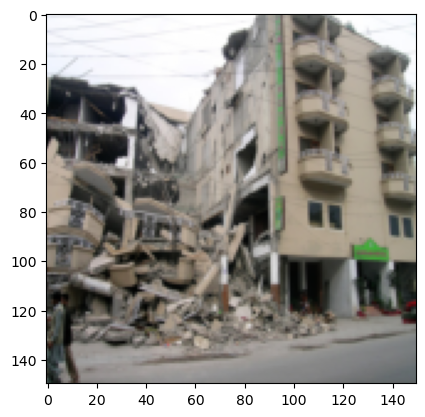

In [6]:
show_example(*training_set[89])

In [7]:
val_size = 200  
train_size = len(training_set) - val_size
train_ds, val_ds = random_split(training_set, [train_size, val_size])
len(train_ds), len(val_ds)

(200, 200)

## Creating training dataset

In [8]:
batch_size=64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [9]:
#categories
root=pathlib.Path("Task2_dataset//training")
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['Combat',
 'DestroyedBuildings',
 'Fire',
 'Humanitarian Aid and rehabilitation',
 'Military vehicles and weapons']

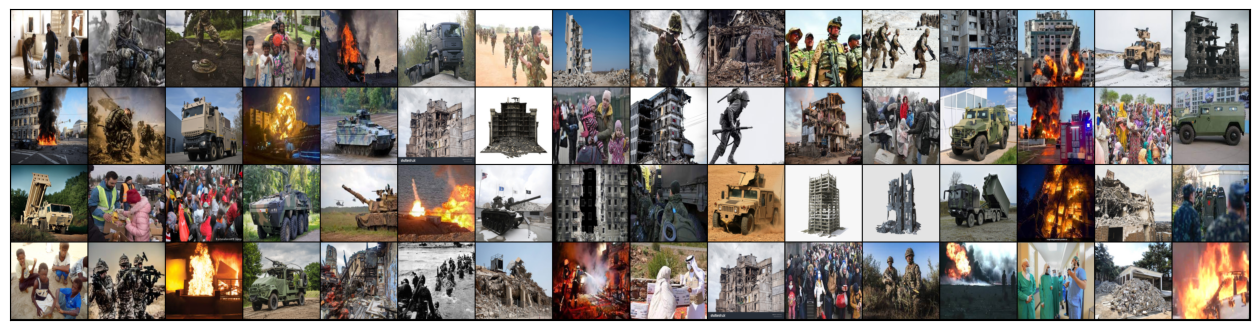

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

## Creating neural Network architecture


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class CovNet(nn.Module):
    def __init__(self,num_classes=5):
        super(CovNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)


        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
        
    


In [12]:
w=150
f=3
p=1
s=1

output=int(((w-f+2*p)/s) +1)
output

150

In [13]:
model=CovNet(num_classes=5)
model

CovNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=5, bias=True)
)

In [14]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.003,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [15]:
best_accuracy=0.0
no_of_epochs=15
for epoch in range(no_of_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss*images.size(0)  
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/250
    train_loss=train_loss/250
    

    test_accuracy=0.0
    for i, (images,labels) in enumerate(val_dl):
        
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/150
    
    
    print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

Epoch: 1 Train Loss: tensor(72.5115, grad_fn=<DivBackward0>) Train Accuracy: 0.208 Test Accuracy: 0.44666666666666666
Epoch: 2 Train Loss: tensor(97.8878, grad_fn=<DivBackward0>) Train Accuracy: 0.232 Test Accuracy: 0.66
Epoch: 3 Train Loss: tensor(26.0074, grad_fn=<DivBackward0>) Train Accuracy: 0.416 Test Accuracy: 0.52
Epoch: 4 Train Loss: tensor(13.1081, grad_fn=<DivBackward0>) Train Accuracy: 0.532 Test Accuracy: 0.48
Epoch: 5 Train Loss: tensor(13.4944, grad_fn=<DivBackward0>) Train Accuracy: 0.484 Test Accuracy: 0.5733333333333334
Epoch: 6 Train Loss: tensor(13.6967, grad_fn=<DivBackward0>) Train Accuracy: 0.548 Test Accuracy: 0.52
Epoch: 7 Train Loss: tensor(8.8204, grad_fn=<DivBackward0>) Train Accuracy: 0.596 Test Accuracy: 0.5533333333333333
Epoch: 8 Train Loss: tensor(5.8440, grad_fn=<DivBackward0>) Train Accuracy: 0.652 Test Accuracy: 0.6533333333333333
Epoch: 9 Train Loss: tensor(3.8194, grad_fn=<DivBackward0>) Train Accuracy: 0.672 Test Accuracy: 0.6466666666666666
Epoch

In [16]:
from PIL import Image
from torch.autograd import Variable
import pandas as pd

test_data = ["building1", "building2", "combat1", "combat2",
             "fire1", "fire2", "military1", "military2", "rehab1", "rehab2"]


def prediction(transformer):
    headers = ["Output Image Name", "  Acutal Image Name"]
    data = []
    for img in test_data:
        img_path = "Task2_dataset//testing/"+img+".jpeg"
        image = Image.open(img_path)
        image_tensor = transformer(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        output = model(input)
        index = output.data.numpy().argmax()
        pred = classes[index]
        data.append([pred, img])
        # print(pred,"\t\t\t")
    print(pd.DataFrame(data, columns=headers))


transformers = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),  # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5],  # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5, 0.5, 0.5])
])
prediction(transformers)


                     Output Image Name   Acutal Image Name
0                               Combat           building1
1                               Combat           building2
2  Humanitarian Aid and rehabilitation             combat1
3                               Combat             combat2
4  Humanitarian Aid and rehabilitation               fire1
5                                 Fire               fire2
6                               Combat           military1
7        Military vehicles and weapons           military2
8  Humanitarian Aid and rehabilitation              rehab1
9                                 Fire              rehab2
